# Titanic - Machine Learning from Disaster

https://www.kaggle.com/c/titanic/

In [1]:
import os

In [3]:
PROJECT_ROOT_DIR = "/home/jupyter/kaggle"
TITANIC_PATH = os.path.join(PROJECT_ROOT_DIR, "datasets", "titanic")

In [4]:
import pandas as pd

In [5]:
def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [6]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

In [7]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [11]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [12]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [13]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

In [15]:
# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [16]:
from sklearn.pipeline import Pipeline

In [17]:
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

In [18]:
num_pipeline = Pipeline([
    ("select_num", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
    ("imputer", SimpleImputer(strategy="median"))
])

In [19]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

In [20]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [21]:
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

In [22]:
cat_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
    ("imputer", MostFrequentImputer()),
    ("cat_encoder", OneHotEncoder(sparse=False))
])

In [23]:
import numpy as np

np.set_printoptions(threshold=np.inf) # show all columns in ndarray

In [24]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., 0., 1., 0., 0., 1.],
       [1., 0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0., 0., 1.],
       [0., 1., 0., 1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0., 0., 1.],
       [0., 0., 1., 1., 0., 1., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 1.],
       [0., 1., 0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 

In [25]:
from sklearn.pipeline import FeatureUnion

In [26]:
preprocess_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

In [27]:
X_train = preprocess_pipeline.fit_transform(train_data)

In [28]:
X_train

array([[2.200000e+01, 1.000000e+00, 0.000000e+00, 7.250000e+00,
        0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        1.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00],
       [3.800000e+01, 1.000000e+00, 0.000000e+00, 7.128330e+01,
        1.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00,
        0.000000e+00, 1.000000e+00, 0.000000e+00, 0.000000e+00],
       [2.600000e+01, 0.000000e+00, 0.000000e+00, 7.925000e+00,
        0.000000e+00, 0.000000e+00, 1.000000e+00, 1.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00],
       [3.500000e+01, 1.000000e+00, 0.000000e+00, 5.310000e+01,
        1.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00],
       [3.500000e+01, 0.000000e+00, 0.000000e+00, 8.050000e+00,
        0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        1.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00],
       [2.800000e+01, 0.000000e+00,

In [29]:
y_train = train_data["Survived"]

In [30]:
y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [31]:
from sklearn.linear_model import SGDClassifier

In [32]:
sgd_clf = SGDClassifier(random_state=42)

In [33]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [34]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = sgd_clf.predict(X_test)

In [35]:
from sklearn.model_selection import cross_val_score

In [36]:
sgd_scores = cross_val_score(sgd_clf, X_train, y_train, cv=10)
sgd_scores.mean()

0.6936704119850188

In [37]:
from sklearn.svm import SVC

In [38]:
svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(gamma='auto')

In [39]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

In [40]:
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7329588014981274

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [43]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8126466916354558

In [44]:
from sklearn.neighbors import KNeighborsClassifier

In [45]:
knn_clf = KNeighborsClassifier()

In [46]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [47]:
knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=10)
knn_scores.mean()

0.7172659176029963

In [48]:
import matplotlib.pyplot as plt

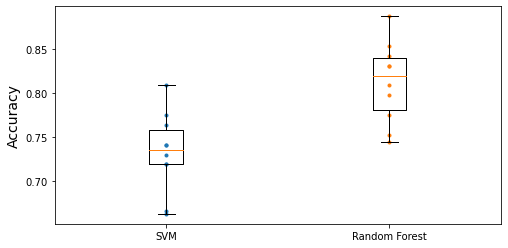

In [49]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".") # [1]*10 => ten times number 1
plt.plot([2]*10, forest_scores, ".") # [2]*10 => ten times number 2
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [50]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [51]:
num_pipeline = Pipeline([
    ("select_num", DataFrameSelector(["AgeBucket", "SibSp", "Parch", "Fare"])),
    ("imputer", SimpleImputer(strategy="median"))
])

In [52]:
preprocess_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

In [53]:
X_train = preprocess_pipeline.fit_transform(train_data)

In [54]:
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7542821473158552

In [55]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8103620474406992

In [56]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [57]:
num_pipeline = Pipeline([
    ("select_num", DataFrameSelector(["AgeBucket", "RelativesOnboard", "Fare"])),
    ("imputer", SimpleImputer(strategy="median"))
])

In [58]:
preprocess_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

In [59]:
X_train = preprocess_pipeline.fit_transform(train_data)

In [60]:
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7565543071161048

In [61]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8159925093632958

In [62]:
train_data = train_data.drop(["AgeBucket", "RelativesOnboard"], axis=1)

In [63]:
corr_matrix = train_data.corr()

In [64]:
corr_matrix

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [65]:
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

In [66]:
from sklearn.model_selection import GridSearchCV

In [67]:
param_grid = [
    {"loss": ["hinge", "log", "modified_huber", "squared_hinge", "perceptron", "squared_loss", "huber", "epsilon_insensitive", "squared_epsilon_insensitive"],
     "penalty": ["l2", "l1", "elasticnet"]}
]

In [68]:
grid_search = GridSearchCV(sgd_clf, param_grid, cv=10)

In [69]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SGDClassifier(random_state=42),
             param_grid=[{'loss': ['hinge', 'log', 'modified_huber',
                                   'squared_hinge', 'perceptron',
                                   'squared_loss', 'huber',
                                   'epsilon_insensitive',
                                   'squared_epsilon_insensitive'],
                          'penalty': ['l2', 'l1', 'elasticnet']}])

In [70]:
grid_search.best_params_

{'loss': 'perceptron', 'penalty': 'l1'}

In [71]:
grid_search.best_score_

0.764294631710362

In [72]:
param_grid = [
    {"n_estimators": [1, 10, 100]}
]

In [73]:
grid_search = GridSearchCV(forest_clf, param_grid, cv=10)

In [74]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'n_estimators': [1, 10, 100]}])

In [75]:
grid_search.best_estimator_

RandomForestClassifier(n_estimators=10, random_state=42)

In [76]:
grid_search.best_score_

0.8171161048689137

In [77]:
param_grid = [
    {"n_neighbors": [1, 10, 100],
     "weights": ["uniform", "distance"],
     "algorithm": ["ball_tree", "kd_tree", "brute"],
     "p": [1, 2]}
]

In [78]:
grid_search = GridSearchCV(knn_clf, param_grid, cv=10)

In [79]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid=[{'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'n_neighbors': [1, 10, 100], 'p': [1, 2],
                          'weights': ['uniform', 'distance']}])

In [80]:
grid_search.best_params_

{'algorithm': 'brute', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}

In [81]:
grid_search.best_score_

0.7912609238451935

In [82]:
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if big_string.find(substring) != -1:
            return substring
    print(big_string)
    return np.nan

In [83]:
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
            'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
            'Don', 'Jonkheer']

In [84]:
train_data["Title"]=train_data["Name"].map(lambda x: substrings_in_string(x, title_list))

In [85]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr


In [86]:
def replace_titles(x):
    title=x['Title']
    
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

In [87]:
train_data["Title"]=train_data.apply(replace_titles, axis=1)

In [88]:
train_data["Title"].value_counts()

Mr        531
Miss      182
Mrs       138
Master     40
Name: Title, dtype: int64

In [89]:
num_pipeline = Pipeline([
    ("select_num", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
    ("imputer", SimpleImputer(strategy="median"))
])

In [90]:
num_pipeline.fit_transform(train_data)

array([[2.200000e+01, 1.000000e+00, 0.000000e+00, 7.250000e+00],
       [3.800000e+01, 1.000000e+00, 0.000000e+00, 7.128330e+01],
       [2.600000e+01, 0.000000e+00, 0.000000e+00, 7.925000e+00],
       [3.500000e+01, 1.000000e+00, 0.000000e+00, 5.310000e+01],
       [3.500000e+01, 0.000000e+00, 0.000000e+00, 8.050000e+00],
       [2.800000e+01, 0.000000e+00, 0.000000e+00, 8.458300e+00],
       [5.400000e+01, 0.000000e+00, 0.000000e+00, 5.186250e+01],
       [2.000000e+00, 3.000000e+00, 1.000000e+00, 2.107500e+01],
       [2.700000e+01, 0.000000e+00, 2.000000e+00, 1.113330e+01],
       [1.400000e+01, 1.000000e+00, 0.000000e+00, 3.007080e+01],
       [4.000000e+00, 1.000000e+00, 1.000000e+00, 1.670000e+01],
       [5.800000e+01, 0.000000e+00, 0.000000e+00, 2.655000e+01],
       [2.000000e+01, 0.000000e+00, 0.000000e+00, 8.050000e+00],
       [3.900000e+01, 1.000000e+00, 5.000000e+00, 3.127500e+01],
       [1.400000e+01, 0.000000e+00, 0.000000e+00, 7.854200e+00],
       [5.500000e+01, 0.0

In [91]:
cat_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked", "Title"])),
    ("imputer", MostFrequentImputer()),
    ("cat_encoder", OneHotEncoder(sparse=False))
])

In [92]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0.,

In [93]:
preprocess_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

In [94]:
X_train = preprocess_pipeline.fit_transform(train_data)

In [95]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [96]:
param_grid = [
    {"n_estimators": [1, 10, 100]}
]

In [97]:
grid_search = GridSearchCV(forest_clf, param_grid, cv=10)

In [98]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'n_estimators': [1, 10, 100]}])

In [99]:
grid_search.best_estimator_

RandomForestClassifier(random_state=42)

In [100]:
grid_search.best_score_

0.8126466916354556

In [101]:
train_data = train_data.drop("Title", axis=1)

In [102]:
num_pipeline = Pipeline([
    ("select_num", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
    ("imputer", SimpleImputer(strategy="median"))
])

In [103]:
cat_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
    ("imputer", MostFrequentImputer()),
    ("cat_encoder", OneHotEncoder(sparse=False))
])

In [104]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., 0., 1., 0., 0., 1.],
       [1., 0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0., 0., 1.],
       [0., 1., 0., 1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0., 0., 1.],
       [0., 0., 1., 1., 0., 1., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 1.],
       [0., 1., 0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 

In [105]:
preprocess_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

In [106]:
X_train = preprocess_pipeline.fit_transform(train_data)

In [107]:
param_grid = [
    {"n_estimators": [1, 10, 100]}
]

In [108]:
forest_clf = RandomForestClassifier()

In [109]:
grid_search = GridSearchCV(forest_clf, param_grid, cv=10)

In [110]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid=[{'n_estimators': [1, 10, 100]}])

In [111]:
grid_search.best_estimator_

RandomForestClassifier()

In [112]:
grid_search.best_score_

0.8081897627965045

In [113]:
y_pred = grid_search.predict(X_train)

In [114]:
from sklearn.metrics import accuracy_score

In [115]:
accuracy_score(y_train, y_pred)

0.9797979797979798

In [116]:
X_test = preprocess_pipeline.transform(test_data)

In [117]:
y_pred = grid_search.predict(X_test)

In [118]:
y_pred

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [119]:
y_test = pd.DataFrame({'PassengerId':test_data["PassengerId"], 'Survived':y_pred})

In [120]:
def save_titanic_data(df, filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    df.to_csv(csv_path, index=False)

In [121]:
save_titanic_data(y_test, "prediction.csv")